## Загружаем библиотеки

In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

## Загружаем данные

In [ ]:
!unzip '/content/images.zip' -d /content/  #Извлечем файлы из архива

Archive:  /content/images.zip
  inflating: /content/images/3536-812.jpg  
  inflating: /content/images/3536-813.jpg  
  inflating: /content/images/3536-814.jpg  
  inflating: /content/images/3536-815.jpg  
  inflating: /content/images/3536-816.jpg  
  inflating: /content/images/3536-817.jpg  
  inflating: /content/images/3536-818.jpg  
  inflating: /content/images/3536-823.jpg  
  inflating: /content/images/3536-825.jpg  
  inflating: /content/images/3536-827.jpg  
  inflating: /content/images/3536-828.jpg  
  inflating: /content/images/3536-829.jpg  
  inflating: /content/images/3536-830.jpg  
  inflating: /content/images/3536-831.jpg  
  inflating: /content/images/3536-832.jpg  
  inflating: /content/images/3536-833.jpg  
  inflating: /content/images/3536-834.jpg  
  inflating: /content/images/3536-835.jpg  
  inflating: /content/images/3536-837.jpg  
  inflating: /content/images/3536-838.jpg  
  inflating: /content/images/3536-839.jpg  
  inflating: /content/images/3537-812.jpg  
  

In [ ]:
!unzip '/content/annotated.zip' -d /content/  #Извлечем файлы из архива

Archive:  /content/annotated.zip
  inflating: /content/annotated/3536-812.json  
  inflating: /content/annotated/3536-813.json  
  inflating: /content/annotated/3536-817.json  
  inflating: /content/annotated/3536-818.json  
  inflating: /content/annotated/3536-823.json  
  inflating: /content/annotated/3536-825.json  
  inflating: /content/annotated/3536-832.json  
  inflating: /content/annotated/3536-833.json  
  inflating: /content/annotated/3536-834.json  
  inflating: /content/annotated/3536-837.json  
  inflating: /content/annotated/3537-822.json  
  inflating: /content/annotated/3537-824.json  
  inflating: /content/annotated/3537-825.json  
  inflating: /content/annotated/3537-832.json  
  inflating: /content/annotated/3537-833.json  
  inflating: /content/annotated/3537-835.json  
  inflating: /content/annotated/3537-837.json  
  inflating: /content/annotated/3538-812.json  
  inflating: /content/annotated/3538-819.json  
  inflating: /content/annotated/3538-821.json  
  infla

In [ ]:
def plot(images, gray=False):

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(10,8))
    i=0
    
    for y in range(2):
        if gray:
            axes[y].imshow(images[i], cmap='gray')
        else:
            axes[y].imshow(images[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i+=1
    
    plt.show()

In [ ]:
image_list = sorted(os.listdir('images'), key=lambda x: int(x.split('.')[0])) # лист с названиями
annot_list = sorted(os.listdir('annotated'), key=lambda x: int(x.split('.')[0])) # лист с названиями

for im_fn, ann_fn in zip(image_list, annot_list):
    
    im = cv2.imread(os.path.join('images', im_fn), 0)
    
    ann_path = os.path.join('annotated', ann_fn)
    shape_dicts = get_poly(ann_path)
    im_binary = create_binary_masks(im, shape_dicts)
    
    plot_pair([im, im_binary], gray=True)
    plt.show()
    break

In [ ]:
#!unzip '/content/segmented.zip' -d /content/  #Извлечем файлы из архива

Archive:  /content/segmented.zip
  inflating: /content/segmented/3536812.jpg  
  inflating: /content/segmented/3536813.jpg  
  inflating: /content/segmented/3536814.jpg  
  inflating: /content/segmented/3536815.jpg  
  inflating: /content/segmented/3536816.jpg  
  inflating: /content/segmented/3536817.jpg  
  inflating: /content/segmented/3536818.jpg  
  inflating: /content/segmented/3536823.jpg  
  inflating: /content/segmented/3536825.jpg  
  inflating: /content/segmented/3536827.jpg  
  inflating: /content/segmented/3536828.jpg  
  inflating: /content/segmented/3536829.jpg  
  inflating: /content/segmented/3536830.jpg  
  inflating: /content/segmented/3536831.jpg  
  inflating: /content/segmented/3536832.jpg  
  inflating: /content/segmented/3536833.jpg  
  inflating: /content/segmented/3536834.jpg  


In [ ]:
# Глобальные параметры
img_width = 5000 # Ширина уменьшенной картинки 
img_height =  5000 # Высота уменьшенной картинки 
directory = '/content/' # Указываем путь к обучающей выборке с оригинальными изображения
num_classes = 2 # Количество классов на изображении

## Загрузка изображений



In [ ]:
images_trail = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'images')): # Проходим по всем файлам в каталоге по указанному пути     
    images_trail.append(image.load_img(os.path.join(directory + 'images',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 0.17769956588745117c


In [ ]:
list(images_trail)

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AAF9E50>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA51850>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA51910>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA51A10>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA51B10>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA51C50>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA51D50>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA51E50>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA51F50>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA51C10>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5000x5000 at 0x7F075AA55150>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB siz

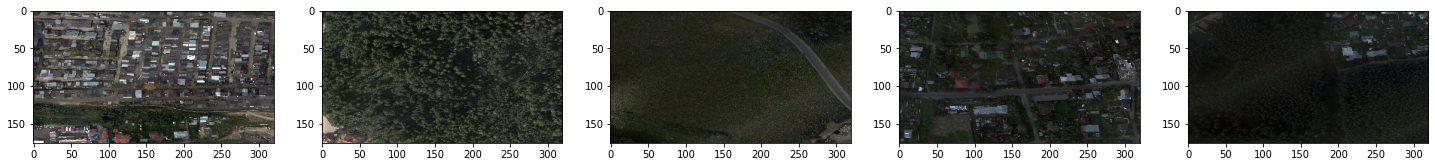

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
    img = random.choice(images_trail) # Выбираем случайное фото для отображения
    axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [ ]:
segments_trail = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'segmented')): # Проходим по всем файлам в каталоге по указанному пути     
    segments_trail.append(image.load_img(os.path.join(directory + 'segmented',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 0.042710065841674805c


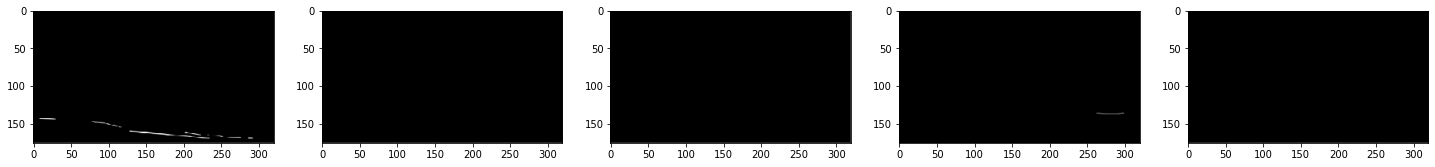

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(segments_trail) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

## Создание выборки



In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (6 классов)
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 20  : index = 1 # тропа 
    return index  

In [ ]:
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # фон
    elif index == 1:
        color = [255, 0, 0]  # тропа
    return color 

In [ ]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
    y_shape = y.shape # Запоминаем форму массива для решейпа
    y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
    yt = [] # Создаем пустой лист
    for i in range(len(y)): # Проходим по всем трем канала изображения
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
    yt = np.array(yt) # Преобразуем в numpy
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Решейпим к исходныму размеру
    return yt # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
    yTrain = [] # Создаем пустой список под карты сегметации
    for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
        y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
        y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
        yTrain.append(y) # Добавляем очередной элемент в yTrain
        if len(yTrain) % 100 == 0: # Каждые 100 шагов
            print(len(yTrain)) # Выводим количество обработанных изображений
    return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images_trail: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(17, 176, 320, 3)


In [ ]:
cur_time = time.time()
yTrain = yt_prep(segments_trail, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c')

Время обработки:  12.39 c


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [ ]:
y_train.shape

(15, 176, 320, 2)

## Обучение модели

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [ ]:
from tensorflow.keras import metrics

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
modelAir = unet(2, (img_width, img_height,3))
history = modelAir.fit(x_train, y_train, epochs=35, batch_size=16, validation_data = (x_val, y_val)) # Обучаем модель на выборке по трем классам

Epoch 1/35
1/1 [==============================] - 83s 83s/step - loss: 0.9501 - dice_coef: 0.4375 - val_loss: 10.9047 - val_dice_coef: 0.0067
Epoch 2/35
1/1 [==============================] - 77s 77s/step - loss: 0.7179 - dice_coef: 0.6156 - val_loss: 10.6385 - val_dice_coef: 0.1050
Epoch 3/35
1/1 [==============================] - 75s 75s/step - loss: 0.3997 - dice_coef: 0.6840 - val_loss: 11.8196 - val_dice_coef: 0.3959
Epoch 4/35
1/1 [==============================] - 76s 76s/step - loss: 0.2582 - dice_coef: 0.7817 - val_loss: 23.5567 - val_dice_coef: 0.5744
Epoch 5/35
1/1 [==============================] - 76s 76s/step - loss: 0.1525 - dice_coef: 0.8658 - val_loss: 27.6757 - val_dice_coef: 0.7715
Epoch 6/35
1/1 [==============================] - 75s 75s/step - loss: 0.0963 - dice_coef: 0.9150 - val_loss: 7.6650 - val_dice_coef: 0.9308
Epoch 7/35
1/1 [==============================] - 76s 76s/step - loss: 0.0680 - dice_coef: 0.9413 - val_loss: 4.3491 - val_dice_coef: 0.9934
Epoch 8/

In [ ]:
modelAir.save_weights('/content/modelTrail.h5')

## Распознавание



In [ ]:
modelAir = unet(2, (img_width, img_height,3))
modelAir.load_weights('/content/modelTrail.h5')

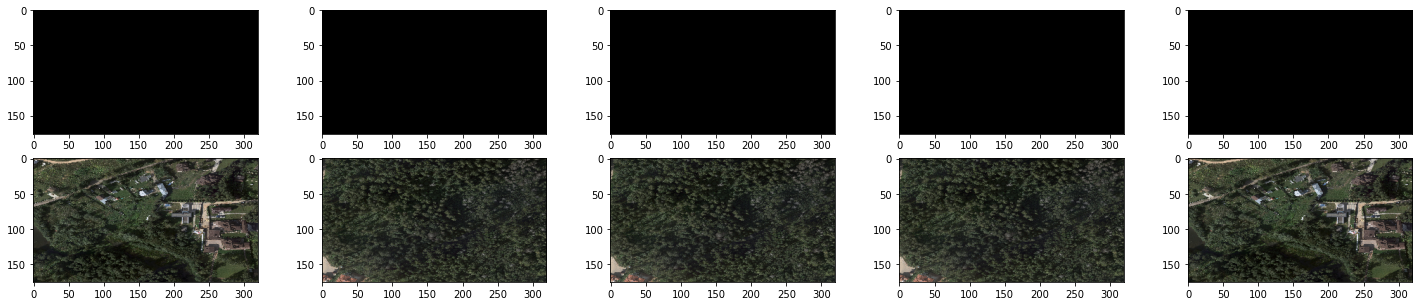

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(modelAir.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
        pr1.append(index2color(pr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
plt.show() 

# Наложение маски

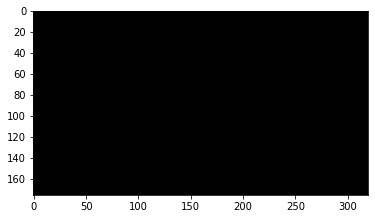

In [ ]:
seg = Image.fromarray(pr1.astype('uint8')).convert('RGBA')
plt.imshow(seg)

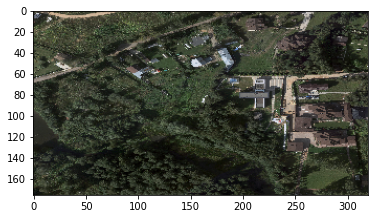

In [ ]:
plt.imshow(Image.fromarray(x_val[idx].astype('uint8')))

In [ ]:
mask = np.array(seg)
mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
mask[mask[:,:,0] > 10] = [0, 150, 0, 150]

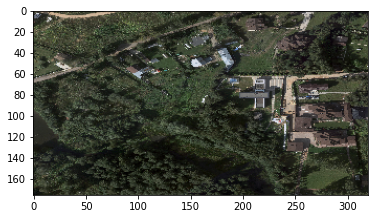

In [ ]:
img2 = Image.fromarray(x_val[idx].astype('uint8'))
img = Image.fromarray(mask).convert('RGBA')
img2.paste(img, (0, 0),img)
plt.imshow(img2)